# Brain Tumor MRI Classification - Complete ML Pipeline

This notebook demonstrates the complete machine learning pipeline for brain tumor classification from MRI images.

## Dataset
- **Source**: Kaggle - Brain Tumor MRI Dataset
- **Classes**: Glioma, Meningioma, No Tumor, Pituitary
- **Structure**: Train/Test split with class subdirectories

## Pipeline Steps:
1. Data Acquisition and Exploration
2. Data Preprocessing and Feature Extraction
3. Model Creation (Transfer Learning)
4. Model Training with Optimization
5. Model Evaluation with Multiple Metrics
6. Model Testing and Prediction


In [1]:
# Import necessary libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# Add parent directory to path to import from src
# Get the current working directory and add parent directory if we're in notebook folder
current_dir = os.getcwd()
if os.path.basename(current_dir) == 'notebook':
    parent_dir = os.path.dirname(current_dir)
    if parent_dir not in sys.path:
        sys.path.insert(0, parent_dir)
else:
    # If running from project root, add current directory
    if current_dir not in sys.path:
        sys.path.insert(0, current_dir)

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Sklearn for evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Import custom modules
try:
    from preprocessing import extract_features_from_directory, prepare_data_for_training, get_class_names
    from model import BrainTumorClassifier
except ImportError:
    from src.preprocessing import extract_features_from_directory, prepare_data_for_training, get_class_names
    from src.model import BrainTumorClassifier

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set up project root path (works whether running from notebook/ or project root)
if os.path.basename(os.getcwd()) == 'notebook':
    PROJECT_ROOT = os.path.dirname(os.getcwd())
else:
    PROJECT_ROOT = os.getcwd()

# Create visualization directory at project root
# All visualizations will be saved to: models/visualizations/
viz_dir = os.path.join(PROJECT_ROOT, 'models', 'visualizations')
os.makedirs(viz_dir, exist_ok=True)

print("TensorFlow version:", tf.__version__)
print(f"Project root: {PROJECT_ROOT}")
print(f"Models directory: {os.path.join(PROJECT_ROOT, 'models')}")
print(f"Visualizations will be saved to: {viz_dir}")


TensorFlow version: 2.20.0
Project root: c:\Users\LENOVO\Desktop\Summative-MLOP-Classification-Pipeline
Models directory: c:\Users\LENOVO\Desktop\Summative-MLOP-Classification-Pipeline\models
Visualizations will be saved to: c:\Users\LENOVO\Desktop\Summative-MLOP-Classification-Pipeline\models\visualizations


## 1. Data Acquisition and Exploration

Let's first explore the dataset structure and understand the data distribution.


Classes found: ['glioma', 'meningioma', 'notumor', 'pituitary']
Number of classes: 4
Training - glioma: 1321 images
Training - meningioma: 1339 images
Training - notumor: 1595 images
Training - pituitary: 1457 images
Test - glioma: 300 images
Test - meningioma: 306 images
Test - notumor: 405 images
Test - pituitary: 300 images


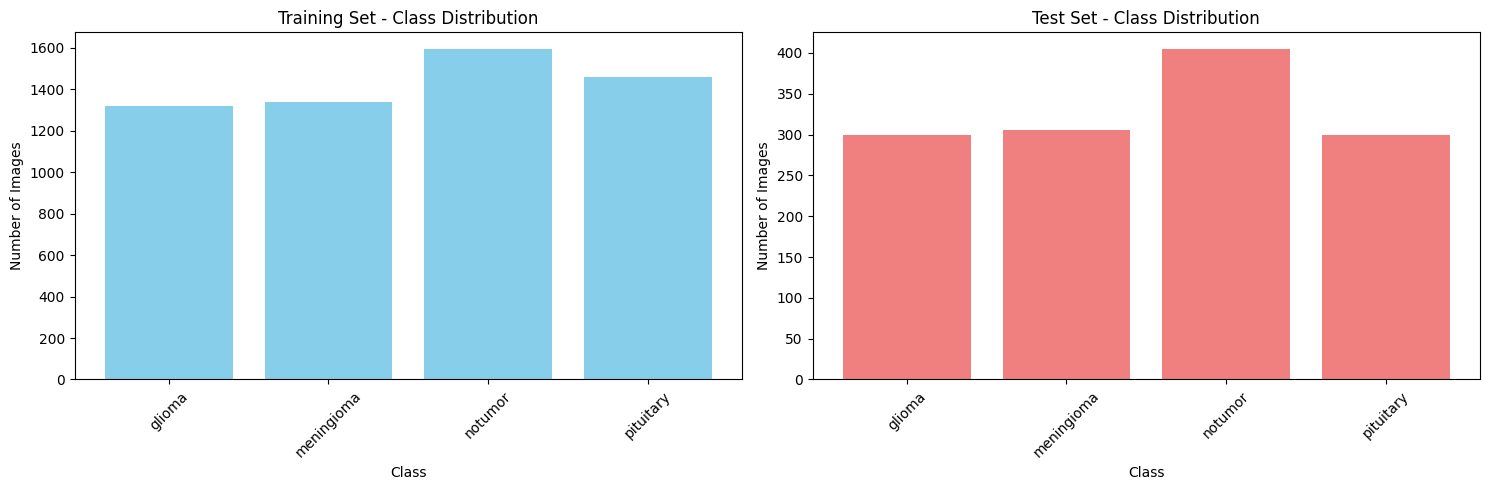


Total training images: 5712
Total test images: 1311
Class distribution plot saved to: c:\Users\LENOVO\Desktop\Summative-MLOP-Classification-Pipeline\models\visualizations\class_distribution.png


In [2]:
# Explore dataset structure
data_dir = os.path.join(PROJECT_ROOT, 'data', 'train')
test_dir = os.path.join(PROJECT_ROOT, 'data', 'test')

# Get class names
class_names = get_class_names(data_dir)
print(f"Classes found: {class_names}")
print(f"Number of classes: {len(class_names)}")

# Count images per class in training set
train_counts = {}
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    if os.path.exists(class_path):
        count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        train_counts[class_name] = count
        print(f"Training - {class_name}: {count} images")

# Count images per class in test set
test_counts = {}
for class_name in class_names:
    class_path = os.path.join(test_dir, class_name)
    if os.path.exists(class_path):
        count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        test_counts[class_name] = count
        print(f"Test - {class_name}: {count} images")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training set distribution
axes[0].bar(train_counts.keys(), train_counts.values(), color='skyblue')
axes[0].set_title('Training Set - Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Images')
axes[0].tick_params(axis='x', rotation=45)

# Test set distribution
axes[1].bar(test_counts.keys(), test_counts.values(), color='lightcoral')
axes[1].set_title('Test Set - Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Number of Images')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'class_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTotal training images: {sum(train_counts.values())}")
print(f"Total test images: {sum(test_counts.values())}")
print(f"Class distribution plot saved to: {os.path.join(viz_dir, 'class_distribution.png')}")


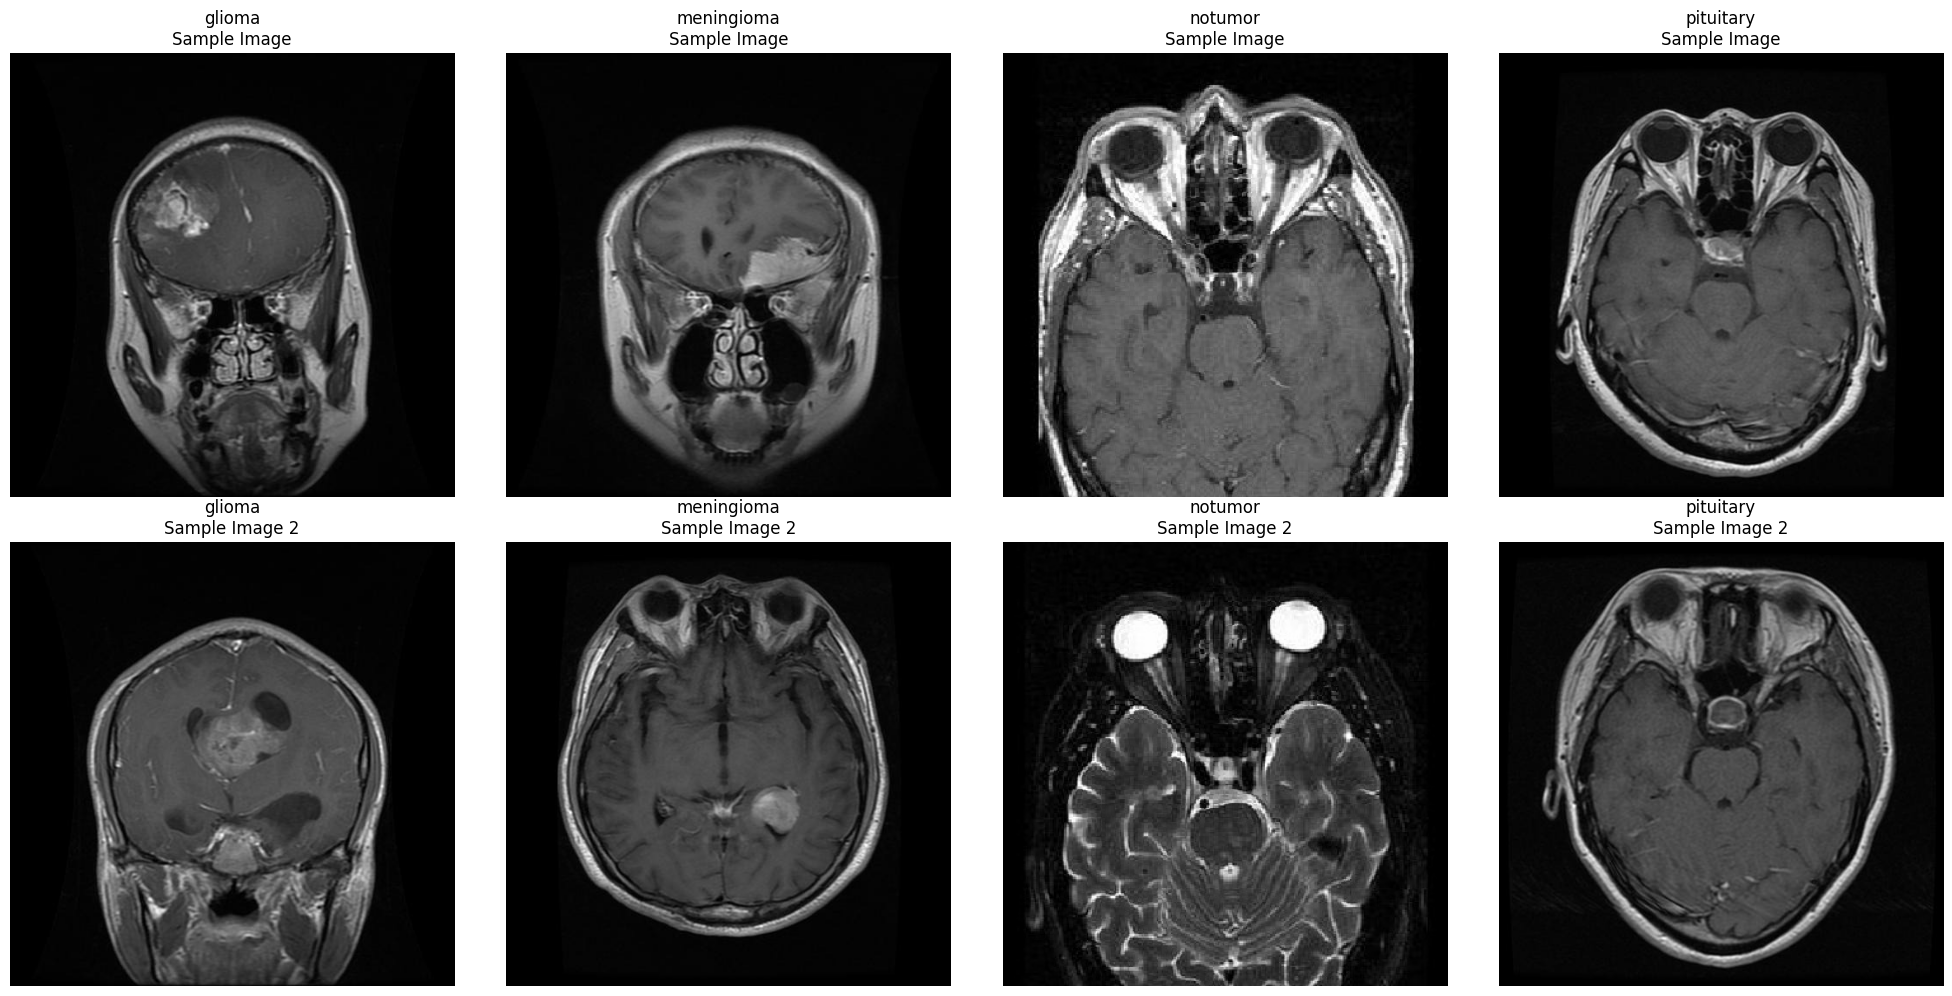

Sample images plot saved to: c:\Users\LENOVO\Desktop\Summative-MLOP-Classification-Pipeline\models\visualizations\sample_images.png


In [3]:
# Display sample images from each class
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, class_name in enumerate(class_names):
    class_path = os.path.join(data_dir, class_name)
    if os.path.exists(class_path):
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if images:
            img_path = os.path.join(class_path, images[0])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[idx].imshow(img)
            axes[idx].set_title(f'{class_name}\nSample Image')
            axes[idx].axis('off')
            axes[idx+4].imshow(cv2.cvtColor(cv2.imread(os.path.join(class_path, images[1] if len(images) > 1 else images[0])), cv2.COLOR_BGR2RGB))
            axes[idx+4].set_title(f'{class_name}\nSample Image 2')
            axes[idx+4].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'sample_images.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"Sample images plot saved to: {os.path.join(viz_dir, 'sample_images.png')}")


## 2. Data Preprocessing and Feature Extraction

Extract features from images and save to CSV for analysis and visualization.


In [4]:
# Extract features from training data
print("Extracting features from training data...")
train_features_df = extract_features_from_directory(data_dir, os.path.join(PROJECT_ROOT, 'data', 'processed', 'image_features_train.csv'))

print(f"\nTraining features shape: {train_features_df.shape}")
print(f"Feature columns: {train_features_df.columns.tolist()}")
print("\nFirst few rows:")
train_features_df.head()


Extracting features from training data...
Found 4 classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Processing 1321 images from glioma...
Processing 1339 images from meningioma...
Processing 1595 images from notumor...
Processing 1457 images from pituitary...
Features saved to c:\Users\LENOVO\Desktop\Summative-MLOP-Classification-Pipeline\data\processed\image_features_train.csv
Total features extracted: 5712
Feature columns: ['hist_mean', 'hist_std', 'hist_median', 'hist_max', 'hist_min', 'mean_intensity', 'std_intensity', 'median_intensity', 'min_intensity', 'max_intensity', 'variance', 'gradient_mean', 'gradient_std', 'width', 'height', 'aspect_ratio', 'image_path', 'class']

Training features shape: (5712, 18)
Feature columns: ['hist_mean', 'hist_std', 'hist_median', 'hist_max', 'hist_min', 'mean_intensity', 'std_intensity', 'median_intensity', 'min_intensity', 'max_intensity', 'variance', 'gradient_mean', 'gradient_std', 'width', 'height', 'aspect_ratio', 'image_path', 'cla

,hist_mean,hist_std,hist_median,hist_max,hist_min,mean_intensity,std_intensity,median_intensity,min_intensity,max_intensity,variance,gradient_mean,gradient_std,width,height,aspect_ratio,image_path,class
0,196.0,938.667358,69.5,12032.0,0.0,31.331433,43.157362,4.0,0,246,1862.557921,47.246231,88.685289,224,224,1.0,c:\Users\LENOVO\Desktop\Summative-MLOP-Classif...,glioma
1,196.0,856.571716,45.0,11283.0,0.0,37.785435,43.340809,5.0,0,242,1878.425741,45.188021,85.281782,224,224,1.0,c:\Users\LENOVO\Desktop\Summative-MLOP-Classif...,glioma
2,196.0,829.073914,32.0,11034.0,0.0,35.977101,40.673852,7.0,0,240,1654.362219,47.078320,89.254661,224,224,1.0,c:\Users\LENOVO\Desktop\Summative-MLOP-Classif...,glioma
3,196.0,857.342712,11.0,11212.0,0.0,24.847816,27.660327,12.0,0,239,765.093709,37.159590,71.483427,224,224,1.0,c:\Users\LENOVO\Desktop\Summative-MLOP-Classif...,glioma
4,196.0,770.261292,16.0,11094.0,0.0,32.013473,33.277927,24.0,0,244,1107.420458,43.175947,75.853839,224,224,1.0,c:\Users\LENOVO\Desktop\Summative-MLOP-Classif...,glioma


In [5]:
# Extract features from test data
print("Extracting features from test data...")
test_features_df = extract_features_from_directory(test_dir, os.path.join(PROJECT_ROOT, 'data', 'processed', 'image_features_test.csv'))

print(f"\nTest features shape: {test_features_df.shape}")
print("\nFirst few rows:")
test_features_df.head()


Extracting features from test data...
Found 4 classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Processing 300 images from glioma...
Processing 306 images from meningioma...
Processing 405 images from notumor...
Processing 300 images from pituitary...
Features saved to c:\Users\LENOVO\Desktop\Summative-MLOP-Classification-Pipeline\data\processed\image_features_test.csv
Total features extracted: 1311
Feature columns: ['hist_mean', 'hist_std', 'hist_median', 'hist_max', 'hist_min', 'mean_intensity', 'std_intensity', 'median_intensity', 'min_intensity', 'max_intensity', 'variance', 'gradient_mean', 'gradient_std', 'width', 'height', 'aspect_ratio', 'image_path', 'class']

Test features shape: (1311, 18)

First few rows:


,hist_mean,hist_std,hist_median,hist_max,hist_min,mean_intensity,std_intensity,median_intensity,min_intensity,max_intensity,variance,gradient_mean,gradient_std,width,height,aspect_ratio,image_path,class
0,196.0,1049.424316,38.5,16107.0,0.0,30.453862,39.377121,6.0,0,245,1550.557621,43.506555,81.265234,224,224,1.0,c:\Users\LENOVO\Desktop\Summative-MLOP-Classif...,glioma
1,196.0,1078.963379,16.5,15820.0,0.0,23.451291,30.964269,3.0,0,245,958.785973,33.727731,64.054250,224,224,1.0,c:\Users\LENOVO\Desktop\Summative-MLOP-Classif...,glioma
2,196.0,1265.025635,10.0,16494.0,0.0,17.328583,25.376095,2.0,0,212,643.946222,22.951393,59.928954,224,224,1.0,c:\Users\LENOVO\Desktop\Summative-MLOP-Classif...,glioma
3,196.0,970.719788,57.5,13995.0,0.0,31.757334,44.737567,5.0,0,252,2001.449922,50.561543,88.285813,224,224,1.0,c:\Users\LENOVO\Desktop\Summative-MLOP-Classif...,glioma
4,196.0,1008.006470,22.0,14788.0,0.0,24.951431,32.547691,4.0,0,241,1059.352173,34.397313,65.742080,224,224,1.0,c:\Users\LENOVO\Desktop\Summative-MLOP-Classif...,glioma


Feature Statistics by Class:
           hist_mean                                                hist_std  \
               count   mean  std    min    25%    50%    75%    max    count   
class                                                                          
glioma        1321.0  196.0  0.0  196.0  196.0  196.0  196.0  196.0   1321.0   
meningioma    1339.0  196.0  0.0  196.0  196.0  196.0  196.0  196.0   1339.0   
notumor       1595.0  196.0  0.0  196.0  196.0  196.0  196.0  196.0   1595.0   
pituitary     1457.0  196.0  0.0  196.0  196.0  196.0  196.0  196.0   1457.0   

                        ... height        aspect_ratio                      \
                  mean  ...    75%    max        count mean  std  min  25%   
class                   ...                                                  
glioma      883.896545  ...  224.0  224.0       1321.0  1.0  0.0  1.0  1.0   
meningioma  726.147888  ...  224.0  224.0       1339.0  1.0  0.0  1.0  1.0   
notumor     835.6374

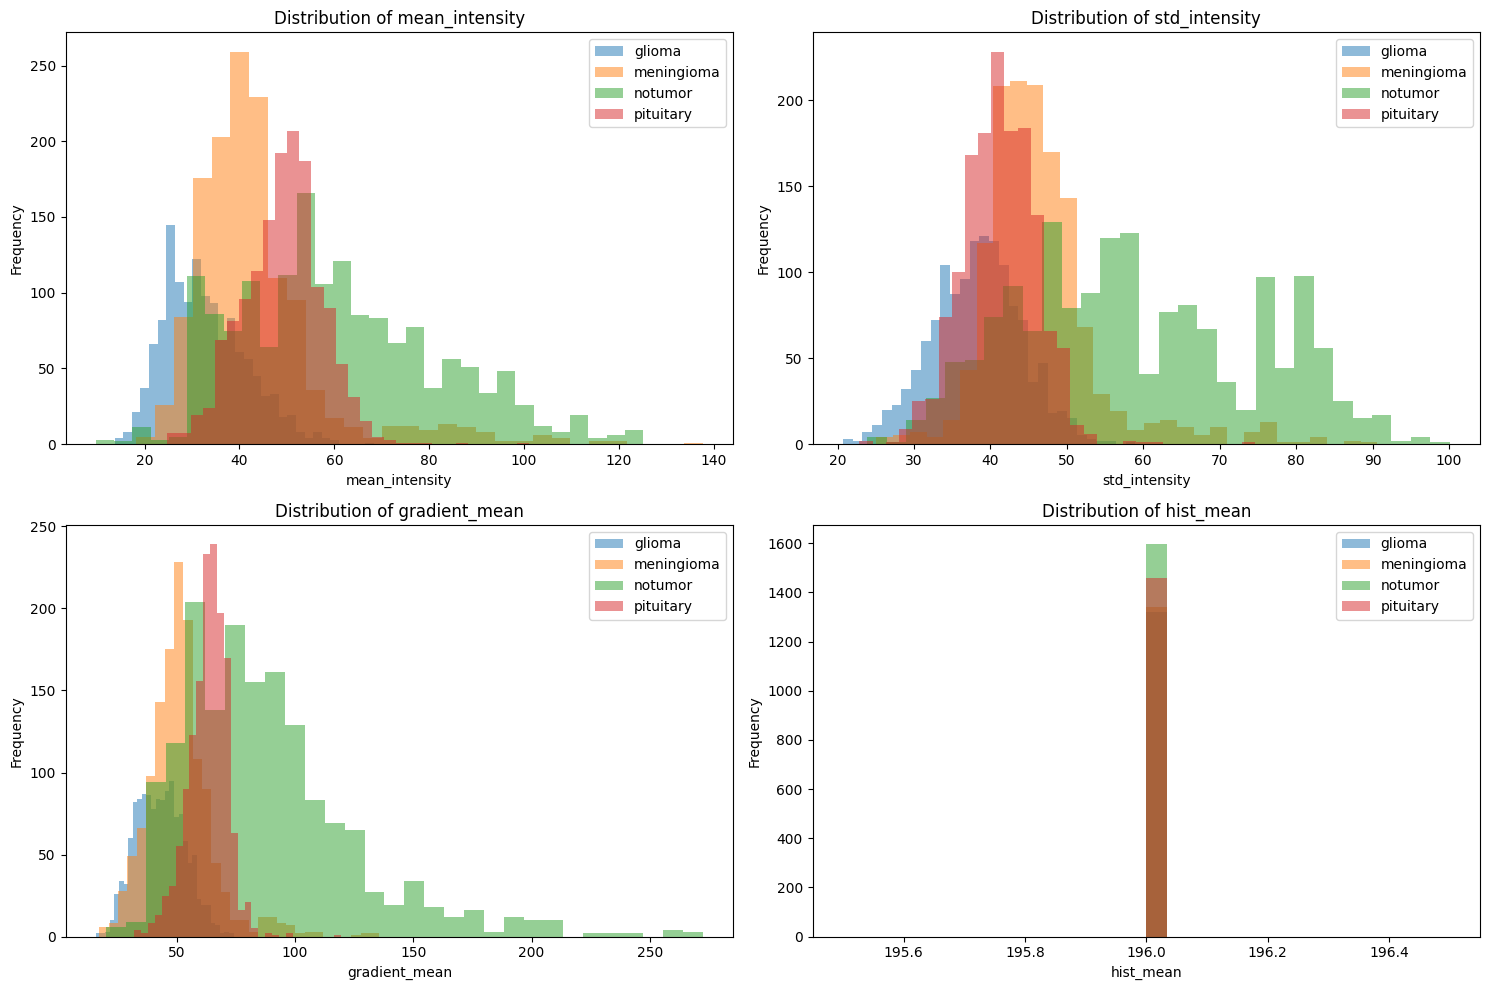

Feature distributions plot saved to: c:\Users\LENOVO\Desktop\Summative-MLOP-Classification-Pipeline\models\visualizations\feature_distributions.png


In [6]:
# Analyze extracted features
if 'class' in train_features_df.columns:
    print("Feature Statistics by Class:")
    print(train_features_df.groupby('class').describe())
    
    # Visualize feature distributions
    numeric_cols = train_features_df.select_dtypes(include=[np.number]).columns.tolist()
    if 'class' in numeric_cols:
        numeric_cols.remove('class')
    
    # Plot distributions for key features
    key_features = ['mean_intensity', 'std_intensity', 'gradient_mean', 'hist_mean']
    available_features = [f for f in key_features if f in numeric_cols]
    
    if available_features:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        for idx, feature in enumerate(available_features[:4]):
            for class_name in class_names:
                class_data = train_features_df[train_features_df['class'] == class_name][feature]
                axes[idx].hist(class_data, alpha=0.5, label=class_name, bins=30)
            axes[idx].set_title(f'Distribution of {feature}')
            axes[idx].set_xlabel(feature)
            axes[idx].set_ylabel('Frequency')
            axes[idx].legend()
        
        plt.tight_layout()
        plt.savefig(os.path.join(viz_dir, 'feature_distributions.png'), dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Feature distributions plot saved to: {os.path.join(viz_dir, 'feature_distributions.png')}")


## 3. Model Creation - Transfer Learning with MobileNetV2

We'll use transfer learning with a pre-trained MobileNetV2 model as the base, then add custom layers for our classification task.


In [7]:
# Prepare data generators with augmentation
print("Preparing data generators...")
train_gen, val_gen = prepare_data_for_training(
    data_dir,
    img_size=(224, 224),
    batch_size=32,
    validation_split=0.2
)

print(f"\nTraining samples: {train_gen.samples}")
print(f"Validation samples: {val_gen.samples}")
print(f"Classes: {list(train_gen.class_indices.keys())}")
print(f"Number of classes: {len(train_gen.class_indices)}")


Preparing data generators...
Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.

Training samples: 4571
Validation samples: 1141
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Number of classes: 4


In [8]:
# Create and build the model
print("Creating model...")
# Ensure models directory is at project root
models_dir = os.path.join(PROJECT_ROOT, 'models')
os.makedirs(models_dir, exist_ok=True)

classifier = BrainTumorClassifier(
    img_size=(224, 224),
    num_classes=len(class_names),
    base_model_name='MobileNetV2',
    models_dir=models_dir
)
classifier.class_names = class_names
classifier.build_model()

# Display model architecture
classifier.model.summary()


Creating model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2560)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2560)      │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │  2,622,464 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024)      │      4,096 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    524,800 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    131,328 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      1,028 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,544,772 (21.15 MB)

 Trainable params: 3,283,204 (12.52 MB)

 Non-trainable params: 2,261,568 (8.63 MB)

## 4. Model Training with Optimization Techniques

We'll use several optimization techniques:
- **Early Stopping**: Prevent overfitting
- **Learning Rate Reduction**: Adaptive learning rate
- **Data Augmentation**: Increase dataset diversity
- **Dropout Regularization**: Prevent overfitting
- **Batch Normalization**: Stabilize training
- **Fine-tuning**: Unfreeze and retrain top layers


In [9]:
# Create models directory
models_dir = os.path.join(PROJECT_ROOT, 'models')
os.makedirs(models_dir, exist_ok=True)

# Train the model
print("Starting model training...")
print("=" * 50)

history = classifier.train(
    train_gen,
    val_gen,
    epochs=25,  # Increased epochs for better convergence (initial training)
    fine_tune_epochs=15  # Increased fine-tuning epochs for >90% accuracy
)

print("\nTraining completed!")


Starting model training...
Phase 1: Training with frozen base model...


c:\Users\LENOVO\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 977ms/step - accuracy: 0.6290 - loss: 1.0583 - precision: 0.6530 - recall: 0.5710
Epoch 1: val_accuracy improved from None to 0.67309, saving model to c:\Users\LENOVO\Desktop\Summative-MLOP-Classification-Pipeline\models\brain_tumor_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.7165 - loss: 0.8142 - precision: 0.7395 - recall: 0.6802 - val_accuracy: 0.6731 - val_loss: 1.3196 - val_precision: 0.6898 - val_recall: 0.6626 - learning_rate: 5.0000e-04
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7866 - loss: 0.5915 - precision: 0.8043 - recall: 0.7695
Epoch 2: val_accuracy improved from 0.67309 to 0.74058, saving model to c:\Users\LENOVO\Desktop\Summative-MLOP-Classification-Pipeline\models\brain_tumor_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.8033 - loss: 0.5521 - precision: 0.8184 - recall: 0.7847 - val_accuracy: 0.7406 - val_loss: 0.8739 - val_precision: 0.7634 - val_recall: 0.7239 - learning_rate: 5.0000e-04
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8206 - loss: 0.5124 - precision: 0.8364 - recall: 0.8056
Epoch 3: val_accuracy improved from 0.74058 to 0.75110, saving model to c:\Users\LENOVO\Desktop\Summative-MLOP-Classification-Pipeline\models\brain_tumor_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.8219 - loss: 0.5027 - precision: 0.8369 - recall: 0.8062 - val_accuracy: 0.7511 - val_loss: 0.7423 - val_precision: 0.7762 - val_recall: 0.7388 - learning_rate: 5.0000e-04
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 922ms/step - accuracy: 0.8347 - loss: 0.4461 - precision: 0.8544 - recall: 0.8196
Epoch 4: val_accuracy improved from 0.75110 to 0.76161, saving model to c:\Users\LENOVO\Desktop\Summative-MLOP-Classification-Pipeline\models\brain_tumor_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.8405 - loss: 0.4361 - precision: 0.8559 - recall: 0.8250 - val_accuracy: 0.7616 - val_loss: 0.7124 - val_precision: 0.7804 - val_recall: 0.7415 - learning_rate: 5.0000e-04
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - accuracy: 0.8459 - loss: 0.4115 - precision: 0.8590 - recall: 0.8308
Epoch 5: val_accuracy did not improve from 0.76161
143/143 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.8440 - loss: 0.4299 - precision: 0.8569 - recall: 0.8296 - val_accuracy: 0.7458 - val_loss: 0.7759 - val_precision: 0.7647 - val_recall: 0.7292 - learning_rate: 5.0000e-04
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - accuracy: 0.8510 - loss: 0.4066 - precision: 0.8647 - recall: 0.8354
Epoch 6: val_accuracy did not improve from 0.76161
143/143 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.8541 - loss: 0.3875 - precision: 0.8708 - recall: 0.8407 - val_accuracy: 0.7301 - val_loss: 0.8397 - val_precision: 0.7544 - val_recall:

143/143 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.8775 - loss: 0.3305 - precision: 0.8880 - recall: 0.8676 - val_accuracy: 0.7651 - val_loss: 0.6320 - val_precision: 0.7903 - val_recall: 0.7397 - learning_rate: 1.5000e-04
Epoch 12/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 920ms/step - accuracy: 0.8679 - loss: 0.3344 - precision: 0.8807 - recall: 0.8569
Epoch 12: val_accuracy did not improve from 0.76512
143/143 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.8729 - loss: 0.3305 - precision: 0.8833 - recall: 0.8606 - val_accuracy: 0.7493 - val_loss: 0.6857 - val_precision: 0.7826 - val_recall: 0.7353 - learning_rate: 1.5000e-04
Epoch 13/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0.8787 - loss: 0.3314 - precision: 0.8897 - recall: 0.8673
Epoch 13: val_accuracy did not improve from 0.76512
143/143 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.8801 - loss: 0.3237 - precision: 0.8920 - recall: 0.8687 - val_accuracy: 0.7564 - val_loss: 0.6609 - val_precision: 0.7814 - val_rec

143/143 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.8751 - loss: 0.3143 - precision: 0.8841 - recall: 0.8661 - val_accuracy: 0.7660 - val_loss: 0.6674 - val_precision: 0.7821 - val_recall: 0.7485 - learning_rate: 4.5000e-05
Epoch 21/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8915 - loss: 0.2904 - precision: 0.9023 - recall: 0.8795
Epoch 21: val_accuracy did not improve from 0.76599
143/143 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.8856 - loss: 0.2988 - precision: 0.8966 - recall: 0.8742 - val_accuracy: 0.7634 - val_loss: 0.6624 - val_precision: 0.7863 - val_recall: 0.7546 - learning_rate: 4.5000e-05
Epoch 22/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8921 - loss: 0.2945 - precision: 0.8998 - recall: 0.8838
Epoch 22: val_accuracy did not improve from 0.76599
143/143 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.8823 - loss: 0.3056 - precision: 0.8906 - recall: 0.8711 - val_accuracy: 0.7642 - val_loss: 0.6844 - val_precision: 0.7855 - val_recall: 0

143/143 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.8893 - loss: 0.2914 - precision: 0.8983 - recall: 0.8777 - val_accuracy: 0.7704 - val_loss: 0.6716 - val_precision: 0.7888 - val_recall: 0.7564 - learning_rate: 4.5000e-05
Epoch 24/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8966 - loss: 0.2908 - precision: 0.9034 - recall: 0.8855
Epoch 24: val_accuracy improved from 0.77038 to 0.77125, saving model to c:\Users\LENOVO\Desktop\Summative-MLOP-Classification-Pipeline\models\brain_tumor_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.8926 - loss: 0.2916 - precision: 0.9006 - recall: 0.8823 - val_accuracy: 0.7713 - val_loss: 0.6488 - val_precision: 0.7889 - val_recall: 0.7599 - learning_rate: 4.5000e-05
Epoch 25/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8853 - loss: 0.2897 - precision: 0.8960 - recall: 0.8766
Epoch 25: val_accuracy did not improve from 0.77125
143/143 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.8854 - loss: 0.2857 - precision: 0.8951 - recall: 0.8760 - val_accuracy: 0.7686 - val_loss: 0.6448 - val_precision: 0.7896 - val_recall: 0.7564 - learning_rate: 4.5000e-05
Restoring model weights from the end of the best epoch: 24.

Phase 2: Fine-tuning...
Unfroze 60 layers for fine-tuning (out of 154 total layers)
Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8158 - loss: 0.5015 - precision: 0.8319 - recall: 0.8015
Epoch 1: val_accuracy did not improve from 0.77125
143/143 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accurac

143/143 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.9110 - loss: 0.2524 - precision: 0.9164 - recall: 0.9035 - val_accuracy: 0.8107 - val_loss: 0.5981 - val_precision: 0.8234 - val_recall: 0.7967 - learning_rate: 5.0000e-05
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9224 - loss: 0.2230 - precision: 0.9262 - recall: 0.9162
Epoch 4: val_accuracy improved from 0.81069 to 0.82559, saving model to c:\Users\LENOVO\Desktop\Summative-MLOP-Classification-Pipeline\models\brain_tumor_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.9230 - loss: 0.2199 - precision: 0.9278 - recall: 0.9162 - val_accuracy: 0.8256 - val_loss: 0.5683 - val_precision: 0.8366 - val_recall: 0.8124 - learning_rate: 5.0000e-05
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9330 - loss: 0.1768 - precision: 0.9390 - recall: 0.9275
Epoch 5: val_accuracy improved from 0.82559 to 0.86065, saving model to c:\Users\LENOVO\Desktop\Summative-MLOP-Classification-Pipeline\models\brain_tumor_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.9337 - loss: 0.1853 - precision: 0.9398 - recall: 0.9287 - val_accuracy: 0.8606 - val_loss: 0.4580 - val_precision: 0.8710 - val_recall: 0.8519 - learning_rate: 5.0000e-05
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9369 - loss: 0.1773 - precision: 0.9414 - recall: 0.9320
Epoch 6: val_accuracy improved from 0.86065 to 0.87204, saving model to c:\Users\LENOVO\Desktop\Summative-MLOP-Classification-Pipeline\models\brain_tumor_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.9401 - loss: 0.1666 - precision: 0.9445 - recall: 0.9348 - val_accuracy: 0.8720 - val_loss: 0.4093 - val_precision: 0.8810 - val_recall: 0.8633 - learning_rate: 5.0000e-05
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9511 - loss: 0.1480 - precision: 0.9534 - recall: 0.9464
Epoch 7: val_accuracy did not improve from 0.87204
143/143 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.9508 - loss: 0.1419 - precision: 0.9544 - recall: 0.9475 - val_accuracy: 0.8712 - val_loss: 0.4031 - val_precision: 0.8830 - val_recall: 0.8668 - learning_rate: 5.0000e-05
Epoch 8/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9528 - loss: 0.1228 - precision: 0.9574 - recall: 0.9502
Epoch 8: val_accuracy did not improve from 0.87204
143/143 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - accuracy: 0.9506 - loss: 0.1348 - precision: 0.9556 - recall: 0.9473 - val_accuracy: 0.8642 - val_loss: 0.4126 - val_precision: 0.8790 - val_recall: 0.859

143/143 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.9600 - loss: 0.1088 - precision: 0.9624 - recall: 0.9576 - val_accuracy: 0.8755 - val_loss: 0.3987 - val_precision: 0.8846 - val_recall: 0.8738 - learning_rate: 5.0000e-05
Epoch 11/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9650 - loss: 0.1039 - precision: 0.9690 - recall: 0.9621
Epoch 11: val_accuracy did not improve from 0.87555
143/143 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.9663 - loss: 0.0972 - precision: 0.9698 - recall: 0.9635 - val_accuracy: 0.8738 - val_loss: 0.3866 - val_precision: 0.8798 - val_recall: 0.8720 - learning_rate: 5.0000e-05
Epoch 12/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9740 - loss: 0.0761 - precision: 0.9761 - recall: 0.9723
Epoch 12: val_accuracy did not improve from 0.87555
143/143 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.9689 - loss: 0.0899 - precision: 0.9710 - recall: 0.9672 - val_accuracy: 0.8677 - val_loss: 0.3913 - val_precision: 0.8748 - val_recall: 0

143/143 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.9692 - loss: 0.0867 - precision: 0.9723 - recall: 0.9676 - val_accuracy: 0.9150 - val_loss: 0.2572 - val_precision: 0.9233 - val_recall: 0.9071 - learning_rate: 5.0000e-05
Epoch 14/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9731 - loss: 0.0817 - precision: 0.9741 - recall: 0.9700
Epoch 14: val_accuracy did not improve from 0.91499
143/143 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.9748 - loss: 0.0823 - precision: 0.9758 - recall: 0.9722 - val_accuracy: 0.9045 - val_loss: 0.2986 - val_precision: 0.9150 - val_recall: 0.8966 - learning_rate: 5.0000e-05
Epoch 15/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9765 - loss: 0.0700 - precision: 0.9776 - recall: 0.9757
Epoch 15: val_accuracy did not improve from 0.91499
143/143 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.9764 - loss: 0.0694 - precision: 0.9776 - recall: 0.9753 - val_accuracy: 0.9150 - val_loss: 0.2541 - val_precision: 0.9213 - val_recall: 0

Training history saved to c:\Users\LENOVO\Desktop\Summative-MLOP-Classification-Pipeline\models\visualizations\training_history.png
Training history plots saved.

LEARNING CURVES


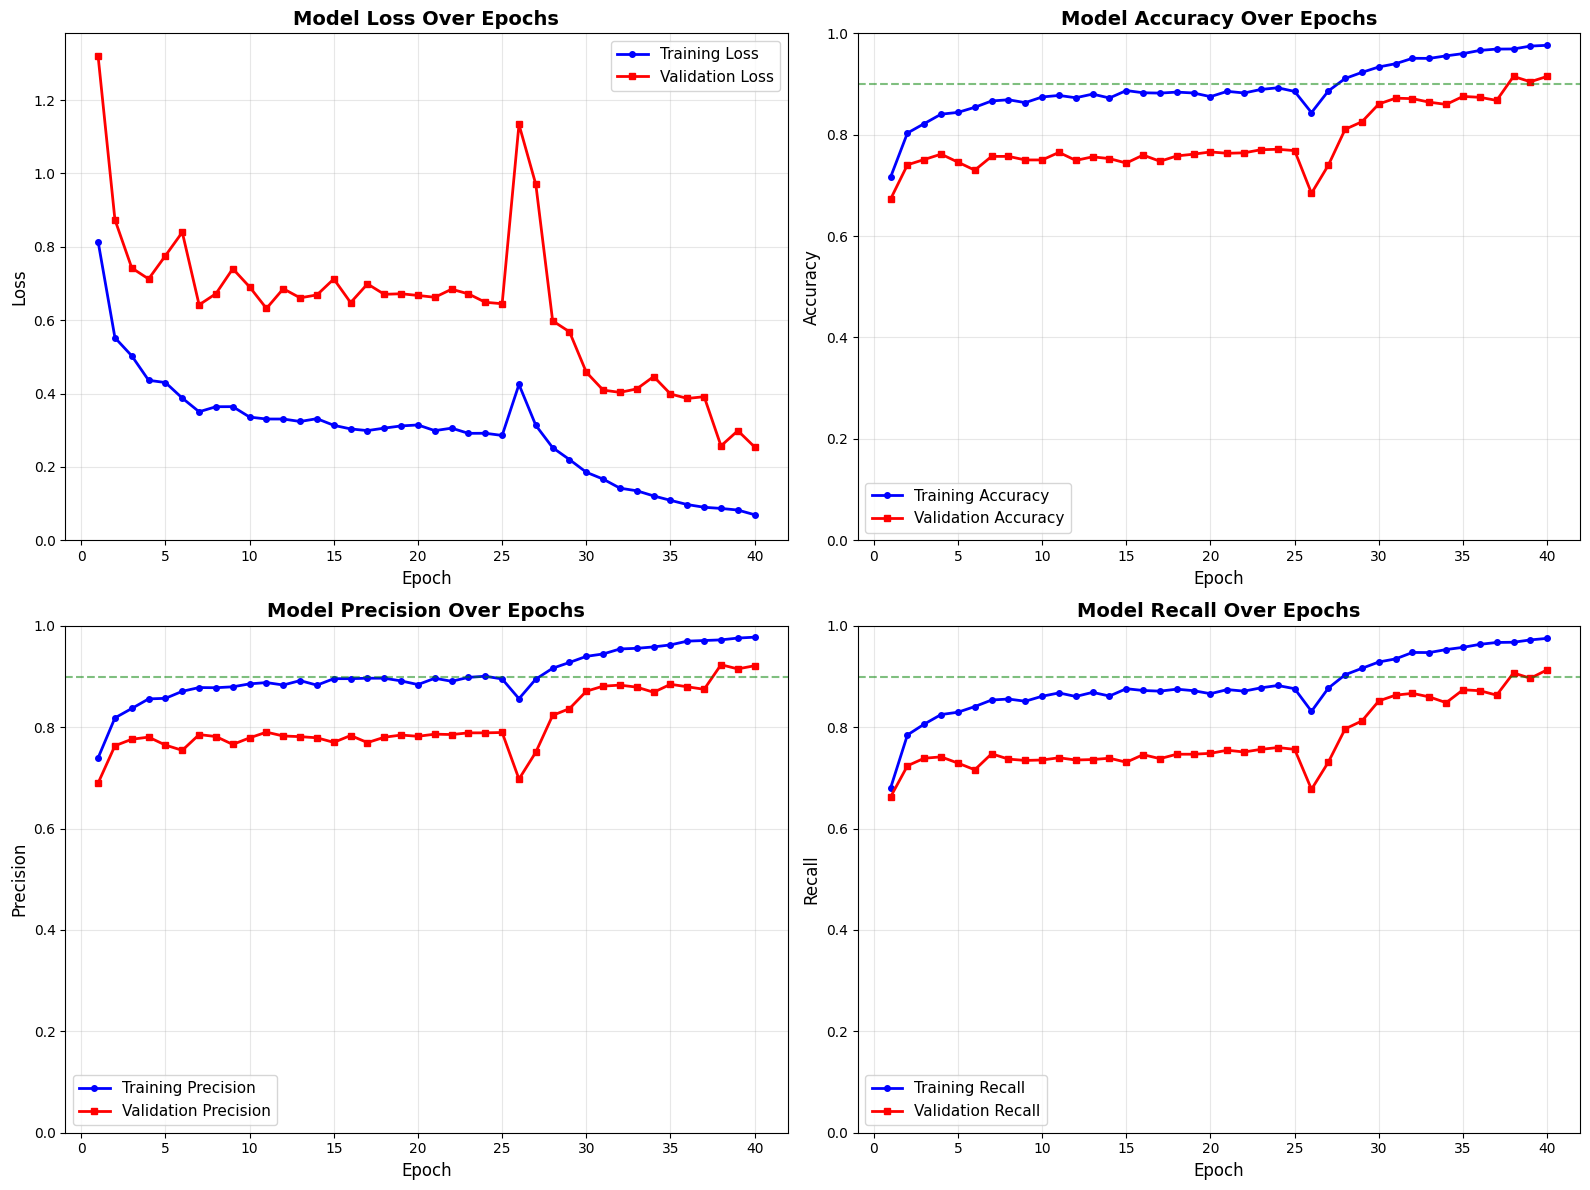


Training Summary:
  Total Epochs: 40
  Final Training Accuracy: 0.9764
  Final Validation Accuracy: 0.9150
  Best Validation Accuracy: 0.9150 (Epoch 38)
  Final Training Loss: 0.0694
  Final Validation Loss: 0.2541
  Best Validation Loss: 0.2541 (Epoch 40)
  Final Validation Precision: 0.9213
  Best Validation Precision: 0.9233
  Final Validation Recall: 0.9132
  Best Validation Recall: 0.9132


In [10]:
# Plot training history and save to file
classifier.plot_training_history(os.path.join(viz_dir, 'training_history.png'))
print("Training history plots saved.")

# Display learning curves in notebook
print("\n" + "=" * 50)
print("LEARNING CURVES")
print("=" * 50)

if classifier.history is not None:
    history = classifier.history.history
    epochs = range(1, len(history['loss']) + 1)
    
    # Create comprehensive learning curves visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Loss curves
    axes[0, 0].plot(epochs, history['loss'], 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)
    axes[0, 0].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss', fontsize=12)
    axes[0, 0].legend(fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim(bottom=0)
    
    # 2. Accuracy curves
    axes[0, 1].plot(epochs, history['accuracy'], 'b-', label='Training Accuracy', linewidth=2, marker='o', markersize=4)
    axes[0, 1].plot(epochs, history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
    axes[0, 1].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Accuracy', fontsize=12)
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim([0, 1])
    axes[0, 1].axhline(y=0.90, color='g', linestyle='--', alpha=0.5, label='90% Target')
    
    # 3. Precision curves
    if 'precision' in history:
        axes[1, 0].plot(epochs, history['precision'], 'b-', label='Training Precision', linewidth=2, marker='o', markersize=4)
        axes[1, 0].plot(epochs, history['val_precision'], 'r-', label='Validation Precision', linewidth=2, marker='s', markersize=4)
        axes[1, 0].set_title('Model Precision Over Epochs', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch', fontsize=12)
        axes[1, 0].set_ylabel('Precision', fontsize=12)
        axes[1, 0].legend(fontsize=11)
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].set_ylim([0, 1])
        axes[1, 0].axhline(y=0.90, color='g', linestyle='--', alpha=0.5, label='90% Target')
    
    # 4. Recall curves
    if 'recall' in history:
        axes[1, 1].plot(epochs, history['recall'], 'b-', label='Training Recall', linewidth=2, marker='o', markersize=4)
        axes[1, 1].plot(epochs, history['val_recall'], 'r-', label='Validation Recall', linewidth=2, marker='s', markersize=4)
        axes[1, 1].set_title('Model Recall Over Epochs', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch', fontsize=12)
        axes[1, 1].set_ylabel('Recall', fontsize=12)
        axes[1, 1].legend(fontsize=11)
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].set_ylim([0, 1])
        axes[1, 1].axhline(y=0.90, color='g', linestyle='--', alpha=0.5, label='90% Target')
    
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, 'learning_curves.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print(f"\nTraining Summary:")
    print(f"  Total Epochs: {len(epochs)}")
    print(f"  Final Training Accuracy: {history['accuracy'][-1]:.4f}")
    print(f"  Final Validation Accuracy: {history['val_accuracy'][-1]:.4f}")
    print(f"  Best Validation Accuracy: {max(history['val_accuracy']):.4f} (Epoch {history['val_accuracy'].index(max(history['val_accuracy'])) + 1})")
    print(f"  Final Training Loss: {history['loss'][-1]:.4f}")
    print(f"  Final Validation Loss: {history['val_loss'][-1]:.4f}")
    print(f"  Best Validation Loss: {min(history['val_loss']):.4f} (Epoch {history['val_loss'].index(min(history['val_loss'])) + 1})")
    
    if 'precision' in history:
        print(f"  Final Validation Precision: {history['val_precision'][-1]:.4f}")
        print(f"  Best Validation Precision: {max(history['val_precision']):.4f}")
    if 'recall' in history:
        print(f"  Final Validation Recall: {history['val_recall'][-1]:.4f}")
        print(f"  Best Validation Recall: {max(history['val_recall']):.4f}")
else:
    print("Training history not available. Please train the model first.")

## 5. Model Evaluation with Multiple Metrics

Evaluate the model using comprehensive metrics:
- Accuracy
- Precision
- Recall
- F1-Score
- Confusion Matrix
- Per-class metrics

In [11]:
# Evaluate on validation set
print("Evaluating model on validation set...")
results = classifier.evaluate(val_gen)

print("\n" + "=" * 50)
print("EVALUATION RESULTS")
print("=" * 50)
print(f"\nOverall Accuracy: {results['accuracy']:.4f}")
print(f"Weighted Precision: {results['precision']:.4f}")
print(f"Weighted Recall: {results['recall']:.4f}")
print(f"Weighted F1-Score: {results['f1_score']:.4f}")

print("\n" + "-" * 50)
print("Per-Class Metrics:")
print("-" * 50)
for class_name in results['class_names']:
    if class_name in results['classification_report']:
        metrics = results['classification_report'][class_name]
        print(f"\n{class_name.upper()}:")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print(f"  F1-Score: {metrics['f1-score']:.4f}")
        print(f"  Support: {metrics['support']}")

Evaluating model on validation set...
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 750ms/step

EVALUATION RESULTS

Overall Accuracy: 0.9150
Weighted Precision: 0.9199
Weighted Recall: 0.9150
Weighted F1-Score: 0.9150

--------------------------------------------------
Per-Class Metrics:
--------------------------------------------------

GLIOMA:
  Precision: 0.9529
  Recall: 0.9205
  F1-Score: 0.9364
  Support: 264.0

MENINGIOMA:
  Precision: 0.8507
  Recall: 0.9176
  F1-Score: 0.8829
  Support: 267.0

NOTUMOR:
  Precision: 0.9818
  Recall: 0.8464
  F1-Score: 0.9091
  Support: 319.0

PITUITARY:
  Precision: 0.8854
  Recall: 0.9828
  F1-Score: 0.9316
  Support: 291.0


Confusion matrix saved to c:\Users\LENOVO\Desktop\Summative-MLOP-Classification-Pipeline\models\visualizations\confusion_matrix_validation.png
Confusion matrix saved.


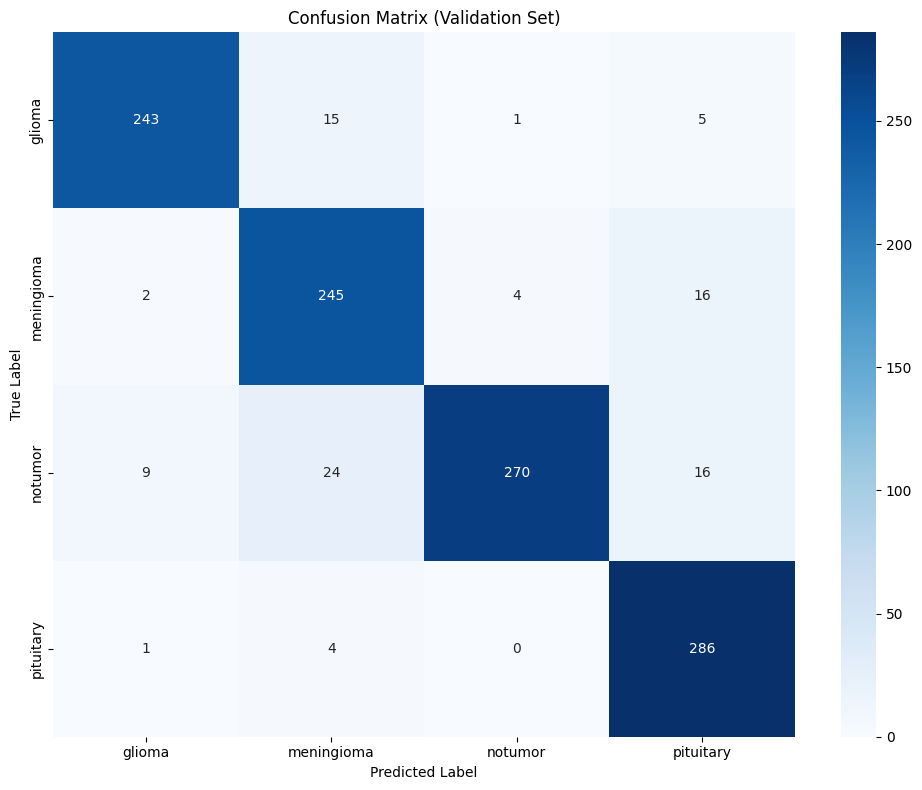

Validation confusion matrix saved to: c:\Users\LENOVO\Desktop\Summative-MLOP-Classification-Pipeline\models\visualizations\confusion_matrix_validation_notebook.png


In [12]:
# Plot confusion matrix
classifier.plot_confusion_matrix(
    results['confusion_matrix'],
    results['class_names'],
    os.path.join(viz_dir, 'confusion_matrix_validation.png')
)
print("Confusion matrix saved.")

# Display confusion matrix in notebook
plt.figure(figsize=(10, 8))
sns.heatmap(
    results['confusion_matrix'],
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=results['class_names'],
    yticklabels=results['class_names']
)
plt.title('Confusion Matrix (Validation Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'confusion_matrix_validation_notebook.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"Validation confusion matrix saved to: {os.path.join(viz_dir, 'confusion_matrix_validation_notebook.png')}")

In [13]:
# Detailed classification report
print("\n" + "=" * 50)
print("DETAILED CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(
    val_gen.classes,
    np.argmax(classifier.model.predict(val_gen), axis=1),
    target_names=results['class_names']
))


DETAILED CLASSIFICATION REPORT
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 731ms/step
              precision    recall  f1-score   support

      glioma       0.95      0.92      0.94       264
  meningioma       0.85      0.92      0.88       267
     notumor       0.98      0.85      0.91       319
   pituitary       0.89      0.98      0.93       291

    accuracy                           0.91      1141
   macro avg       0.92      0.92      0.91      1141
weighted avg       0.92      0.91      0.92      1141



## 6. Model Testing on Test Set

Evaluate the model on the test set to get final performance metrics.

In [14]:
# Prepare test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print(f"Test samples: {test_gen.samples}")
print(f"Test classes: {list(test_gen.class_indices.keys())}")

Found 1311 images belonging to 4 classes.
Test samples: 1311
Test classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


Evaluating model on test set...


c:\Users\LENOVO\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step

TEST SET EVALUATION RESULTS

Test Accuracy: 0.9573
Test Precision: 0.9579
Test Recall: 0.9573
Test F1-Score: 0.9572


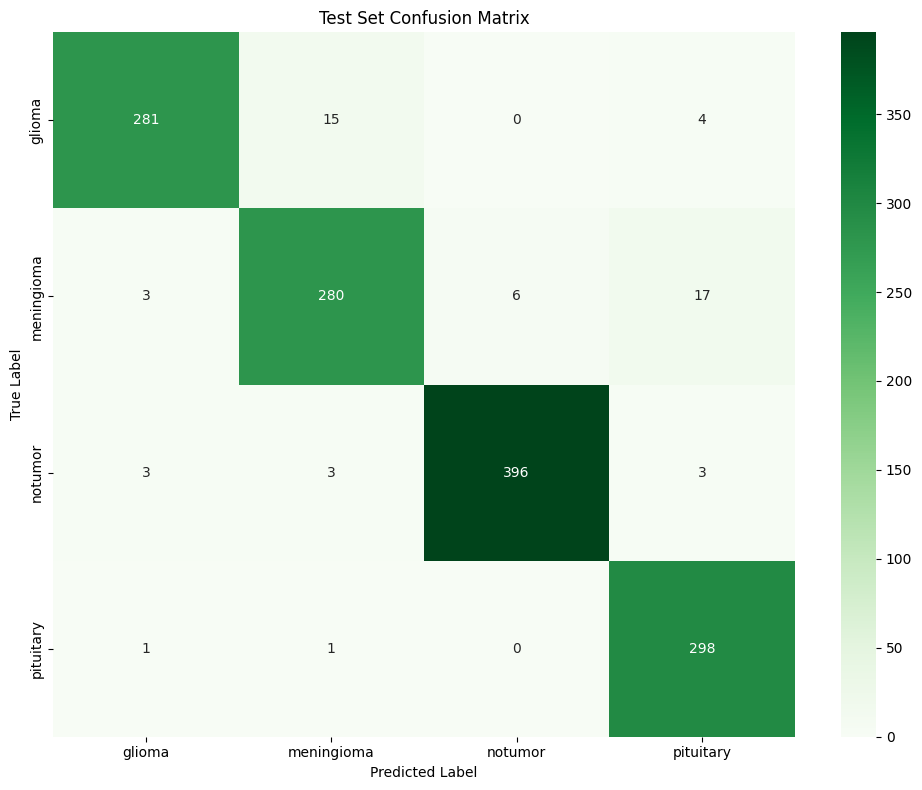

Test confusion matrix saved to: c:\Users\LENOVO\Desktop\Summative-MLOP-Classification-Pipeline\models\visualizations\confusion_matrix_test.png


In [15]:
# Evaluate on test set
print("Evaluating model on test set...")
test_results = classifier.evaluate(test_gen)

print("\n" + "=" * 50)
print("TEST SET EVALUATION RESULTS")
print("=" * 50)
print(f"\nTest Accuracy: {test_results['accuracy']:.4f}")
print(f"Test Precision: {test_results['precision']:.4f}")
print(f"Test Recall: {test_results['recall']:.4f}")
print(f"Test F1-Score: {test_results['f1_score']:.4f}")

# Plot test confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    test_results['confusion_matrix'],
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=test_results['class_names'],
    yticklabels=test_results['class_names']
)
plt.title('Test Set Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'confusion_matrix_test.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"Test confusion matrix saved to: {os.path.join(viz_dir, 'confusion_matrix_test.png')}")

## 7. Model Prediction Functions

Test the model with individual predictions.

In [16]:
# Import prediction module
try:
    from prediction import BrainTumorPredictor
except ImportError:
    from src.prediction import BrainTumorPredictor

# Load predictor
predictor = BrainTumorPredictor(os.path.join(PROJECT_ROOT, 'models', 'brain_tumor_model.h5'))

print("Predictor loaded successfully!")
print(f"Model classes: {predictor.class_names}")

Model loaded successfully. Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Predictor loaded successfully!
Model classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


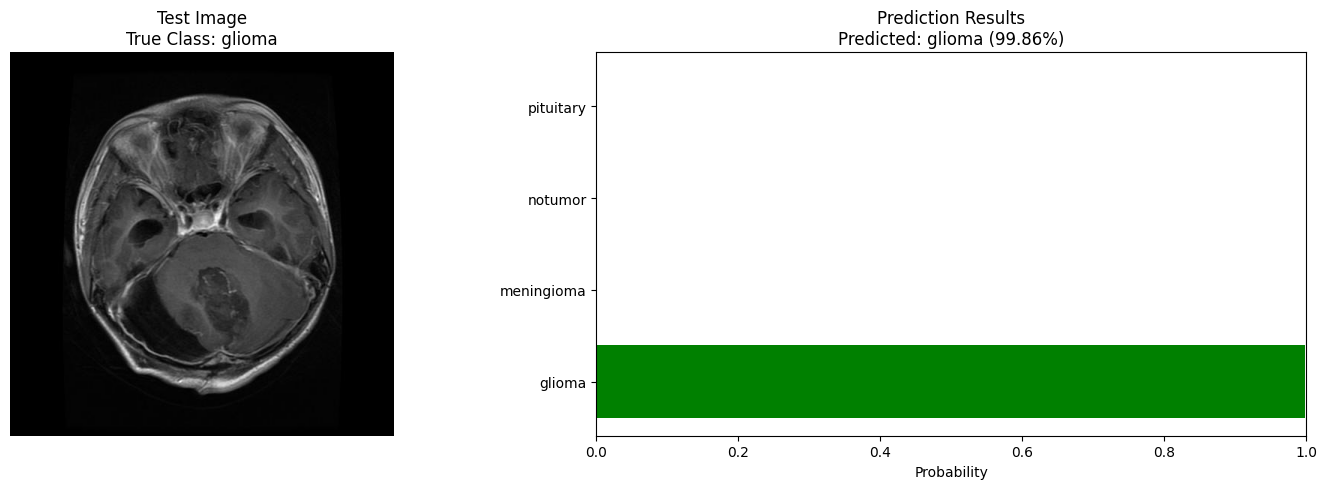


Prediction Results:
Prediction visualization saved to: c:\Users\LENOVO\Desktop\Summative-MLOP-Classification-Pipeline\models\visualizations\sample_prediction.png
True Class: glioma
Predicted Class: glioma
Confidence: 99.86%

All Probabilities:
  glioma: 99.86%
  meningioma: 0.12%
  notumor: 0.02%
  pituitary: 0.01%


In [17]:
# Test prediction on a sample image
sample_class = class_names[0]
sample_path = os.path.join(test_dir, sample_class)
sample_images = [f for f in os.listdir(sample_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

if sample_images:
    test_image_path = os.path.join(sample_path, sample_images[0])
    
    # Make prediction
    result = predictor.predict(test_image_path, return_probabilities=True)
    
    # Display image and prediction
    img = cv2.imread(test_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    axes[0].imshow(img)
    axes[0].set_title(f'Test Image\nTrue Class: {sample_class}')
    axes[0].axis('off')
    
    # Plot probabilities
    classes = list(result['probabilities'].keys())
    probs = list(result['probabilities'].values())
    colors = ['green' if c == result['predicted_class'] else 'gray' for c in classes]
    
    axes[1].barh(classes, probs, color=colors)
    axes[1].set_xlabel('Probability')
    axes[1].set_title(f'Prediction Results\nPredicted: {result["predicted_class"]} ({result["confidence"]*100:.2f}%)')
    axes[1].set_xlim([0, 1])
    
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, 'sample_prediction.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nPrediction Results:")
    print(f"Prediction visualization saved to: {os.path.join(viz_dir, 'sample_prediction.png')}")
    print(f"True Class: {sample_class}")
    print(f"Predicted Class: {result['predicted_class']}")
    print(f"Confidence: {result['confidence']*100:.2f}%")
    print(f"\nAll Probabilities:")
    for class_name, prob in result['probabilities'].items():
        print(f"  {class_name}: {prob*100:.2f}%")

In [18]:
# Save the model
# The ModelCheckpoint callback already saved the best model during training
# to models/brain_tumor_model.h5, so we just need to ensure it's in the right location
model_path = os.path.join(PROJECT_ROOT, 'models', 'brain_tumor_model.h5')

# The checkpoint already saved the best model, but we'll verify and reload to ensure
# we have the best weights (in case training continued after the best epoch)
if os.path.exists(model_path):
    # Load the best model that was saved by ModelCheckpoint
    classifier.model.load_weights(model_path)
    print(f"Loaded best model from: {model_path}")
    
    # Save again to ensure it's the final model
    classifier.save_model(model_path)
    print(f"Model saved to: {model_path}")
else:
    # Fallback: save current model if checkpoint doesn't exist
    classifier.save_model(model_path)
    print(f"Model saved to: {model_path}")

# Save class names
import pickle
with open(os.path.join(PROJECT_ROOT, 'models', 'class_names.pkl'), 'wb') as f:
    pickle.dump(class_names, f)
print("Class names saved!")

Loaded best model from: c:\Users\LENOVO\Desktop\Summative-MLOP-Classification-Pipeline\models\brain_tumor_model.h5


Model saved to c:\Users\LENOVO\Desktop\Summative-MLOP-Classification-Pipeline\models\brain_tumor_model.h5
Model saved to: c:\Users\LENOVO\Desktop\Summative-MLOP-Classification-Pipeline\models\brain_tumor_model.h5
Class names saved!


## Summary

This notebook demonstrated a complete ML pipeline for brain tumor classification:

1. ✅ **Data Exploration**: Analyzed dataset structure and class distribution
2. ✅ **Feature Extraction**: Extracted image features and saved to CSV
3. ✅ **Model Creation**: Built transfer learning model with MobileNetV2
4. ✅ **Optimization**: Applied early stopping, learning rate reduction, data augmentation, dropout, and batch normalization
5. ✅ **Training**: Trained model with fine-tuning
6. ✅ **Evaluation**: Comprehensive evaluation with Accuracy, Precision, Recall, F1-Score, and Confusion Matrix
7. ✅ **Testing**: Evaluated on test set
8. ✅ **Prediction**: Tested prediction functionality

The model is now ready for deployment!
